In [1]:
from galaxy_mnist import GalaxyMNISTHighrez

dataset_train = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=True  # by default, or False for canonical test set
)
# for the testing data
dataset_test = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=False  # by default, or False for canonical test set
)

In [2]:
# Define inputs and labels (targets) for training and testing
images_train = dataset_train.data
images_test = dataset_test.data
labels_train = dataset_train.targets
labels_test = dataset_test.targets

In [4]:
from source.pre import pre_processing
images_trainPre = pre_processing(images_train, 224)
images_testPre = pre_processing(images_test, 224)

In [4]:
"""
#Filter images


import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS
import pandas as pd # for importing data into data frame format

from scipy import ndimage, misc # ndimage: contains various functions for multidimensional image processing
                               # misc: Various utilities that don’t have another home.
import matplotlib.pyplot as plt # to draw images

pre_image_x = ndimage.sobel(
            images_trainPre, mode='nearest', axis=0)
        
pre_image_y= ndimage.sobel(
    images_trainPre ,mode='nearest',axis=1)

pre_image = np.hypot(pre_image_x,pre_image_y)
"""


In [5]:
#pre_image.shape

(8000, 56, 56)

In [6]:
#np.amax(pre_image)

15.216142

### Normalize filter

In [7]:
#pre_image /= np.amax(pre_image)

In [8]:
#np.amax(pre_image)

1.0

### Deep encoder

In [11]:
import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS

import tensorflow as tf #An end-to-end machine learning platform, focusing on training deep learning models
from tensorflow.keras import layers, losses # Implementation of the Keras API, the high-level API of TensorFlow.
from tensorflow.keras.models import Model #This displays graphs 

class GalaxyEncoder(Model):
    def __init__(self):
        super(GalaxyEncoder, self).__init__()
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(224,224,1)),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(16, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            #layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Flatten()
        ])
        self.decoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(6272)),
            layers.Reshape((28, 28, 8)),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(16, (3,3), 1, padding="same", activation="relu"),
            layers.Conv2D(1, (3,3), 1, padding="same", activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
deep_model=GalaxyEncoder()

In [13]:
deep_model.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
deep_model.build((None, 224,224,1))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2)  # Neuronal 
deep_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])

Epoch 1/50
234/250 [===========================>..] - ETA: 15s - loss: 0.0359

In [19]:
encoded_imgs = deep_model.encoder(images_testPre).numpy()
decoded_imgs = deep_model.decoder(encoded_imgs).numpy()

In [20]:
print(decoded_imgs.shape)

(2000, 56, 56, 1)


Original: smooth_round


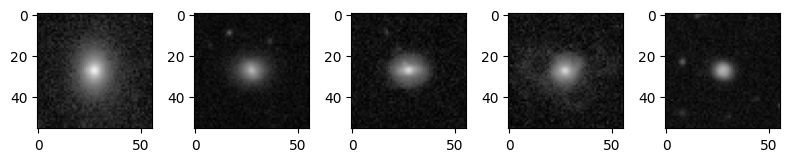

Reconstructed: smooth_round


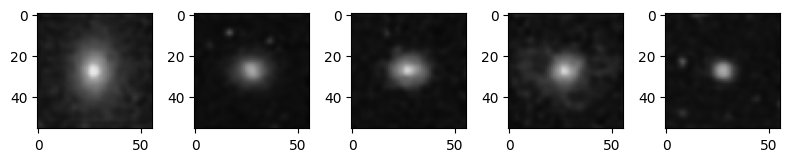

Original: smooth_cigar


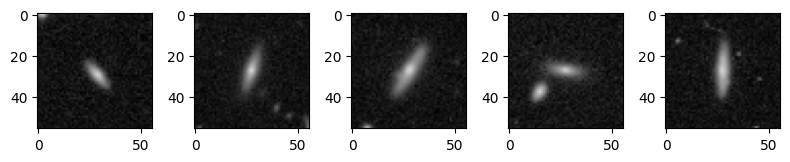

Reconstructed: smooth_cigar


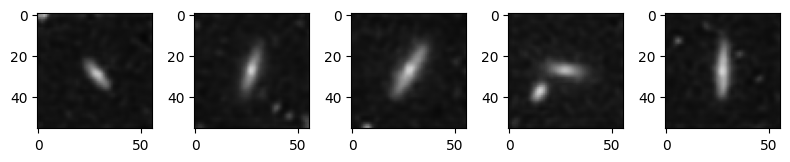

Original: edge_on_disk


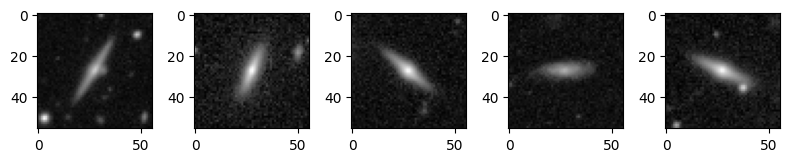

Reconstructed: edge_on_disk


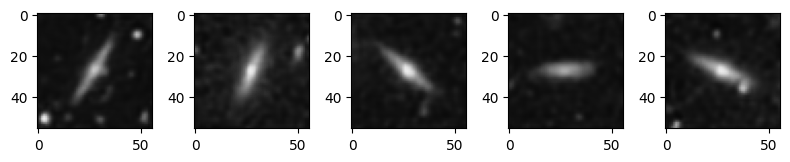

Original: unbarred_spiral


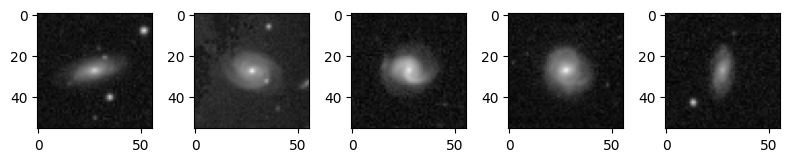

Reconstructed: unbarred_spiral


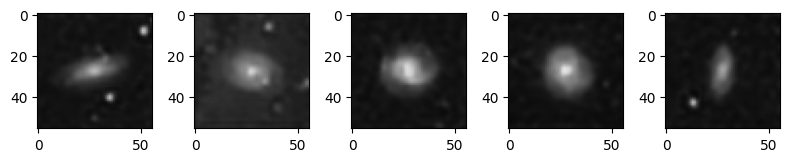

In [21]:
rows = 1
columns = 5
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = images_testPre[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Original: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 
    
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = decoded_imgs[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Reconstructed: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 

In [22]:
deep_model.save("./deepModel_save_filtered")

INFO:tensorflow:Assets written to: ./deepModel_save_filtered/assets


INFO:tensorflow:Assets written to: ./deepModel_save_filtered/assets


In [24]:
import tensorflow as tf
import pandas as pd
model = tf.keras.models.load_model('deepModel_save_filtered/') # recalling the model
print(model.summary())


Model: "galaxy_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1568)              1320      
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
auto_features_train = model.encoder.predict(images_trainPre) # extracting the features for the training data
auto_features_test = model.encoder.predict(images_testPre)   # extracting the features for the testing data

63/63 [==============================] - 0s 5ms/step


In [27]:
auto_df_train = pd.DataFrame(auto_features_train) #turning the data into a dataframe
auto_df_test = pd.DataFrame(auto_features_test) #turning the data into a dataframe

In [28]:
print(auto_df_train.shape) 
auto_df_train

(8000, 1568)


,0,1,2,3,4,5,6,7,8,9,...,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567
0,0.341792,0.238533,0.093446,0.298803,0.601105,0.138509,0.191683,0.275842,0.333060,0.245796,...,0.161451,0.257261,0.341660,0.205644,0.0,0.351184,0.601133,0.116281,0.157059,0.258834
1,0.314954,0.276061,0.104513,0.308293,0.594277,0.113180,0.143942,0.225406,0.333818,0.257008,...,0.147671,0.237329,0.327186,0.192603,0.0,0.326733,0.611568,0.111563,0.147104,0.223987
2,0.333748,0.237414,0.115540,0.271178,0.563540,0.121037,0.153124,0.292543,0.329833,0.251252,...,0.154705,0.513175,0.291900,0.211705,0.0,0.203062,0.485630,0.123651,0.159741,0.444458
3,0.335716,0.235637,0.110503,0.318274,0.560285,0.100336,0.127713,0.338764,0.321493,0.239927,...,0.159921,0.291836,0.287093,0.178554,0.0,0.294530,0.574648,0.150588,0.151609,0.320044
4,0.231860,0.385516,0.311701,0.281142,0.626578,0.092064,0.130944,0.270159,0.314332,0.150564,...,0.135523,0.247603,0.311984,0.224263,0.0,0.310741,0.613243,0.126341,0.151326,0.239216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.313320,0.283458,0.098015,0.261052,0.599069,0.100634,0.140984,0.258332,0.319317,0.233465,...,0.144120,0.297469,0.299563,0.203246,0.0,0.282135,0.587371,0.132896,0.139425,0.284856
7996,0.299316,0.274715,0.135667,0.280019,0.603612,0.098062,0.123717,0.231688,0.321495,0.209371,...,0.125172,0.219483,0.318224,0.222425,0.0,0.290695,0.599234,0.108574,0.154050,0.252879
7997,0.321700,0.298439,0.109162,0.298216,0.589605,0.098000,0.163637,0.294998,0.331257,0.244085,...,0.145631,0.263741,0.284914,0.224026,0.0,0.280388,0.606690,0.154330,0.133443,0.263266
7998,0.355725,0.230958,0.058329,0.302794,0.606979,0.127166,0.133197,0.226552,0.332251,0.279676,...,0.174128,0.263023,0.338825,0.198673,0.0,0.306225,0.595686,0.176129,0.146399,0.316431


### PCA

In [29]:
from sklearn.decomposition import PCA
pca_sample = PCA(n_components=2).fit_transform(np.array(auto_df_train))
print(pca_sample.shape)

(8000, 2)


In [32]:
%store -r classes
from itertools import combinations
comb_class = list(combinations(classes, 2))
print(comb_class)

[('smooth_round', 'smooth_cigar'), ('smooth_round', 'edge_on_disk'), ('smooth_round', 'unbarred_spiral'), ('smooth_cigar', 'edge_on_disk'), ('smooth_cigar', 'unbarred_spiral'), ('edge_on_disk', 'unbarred_spiral')]


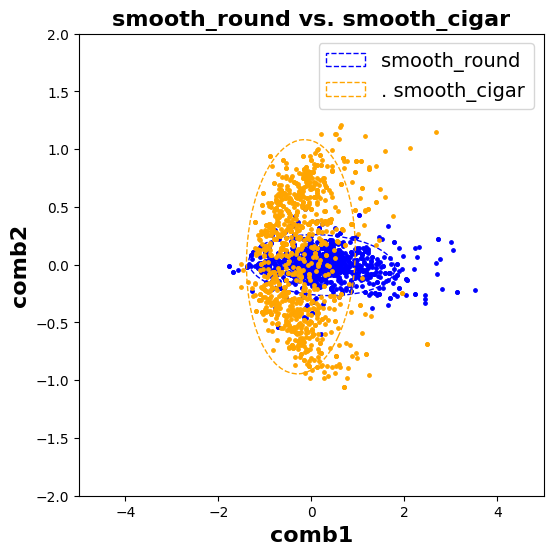

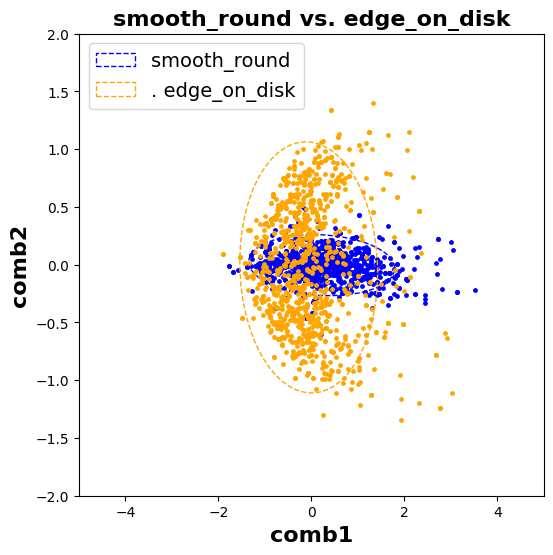

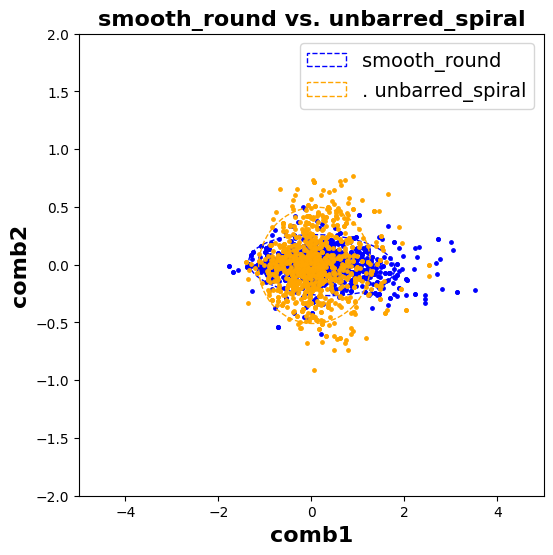

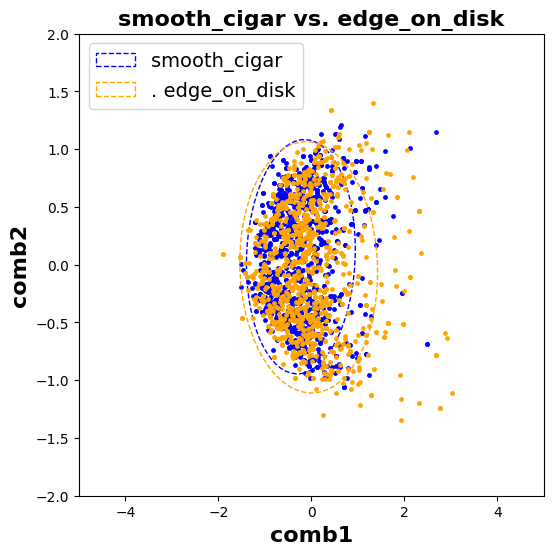

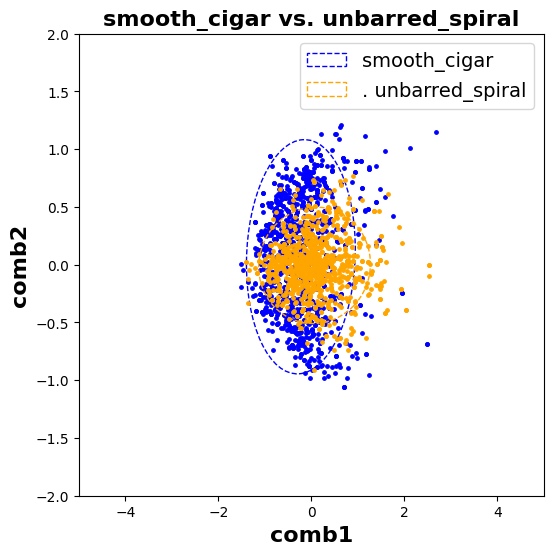

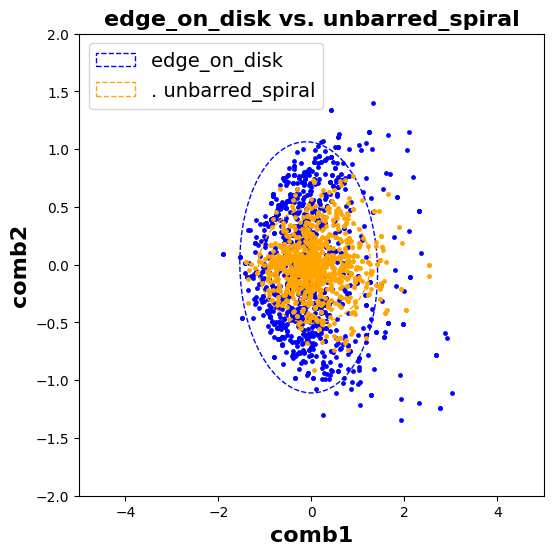

In [34]:
from source.ellipse import draw_confidence_ellipse
np.random.seed(0)
idx = np.random.choice(1992, 1000)
for cc in comb_class:
    class_i = (np.array(labels_train) == classes.index(cc[0]) ) # getting 1000 random samples from the 1st class
    class_j = (np.array(labels_train) == classes.index(cc[1]) ) # getting 1000 random samples from the 2nd class
    
    draw_confidence_ellipse (pca_sample[:, 0][class_i][idx], pca_sample[:, 1][class_i][idx], 
                             pca_sample[:, 0][class_j][idx], pca_sample[:, 1][class_j][idx], 
                             "comb1", "comb2", cc[0]+" vs. "+cc[1], (-5,5), (-2,2))

### TSNE

In [36]:
from sklearn.manifold import TSNE

In [37]:
tsne_sample = TSNE(n_components=2, init='pca', perplexity=10, learning_rate = 10).fit_transform(np.array(auto_df_train)[idx])

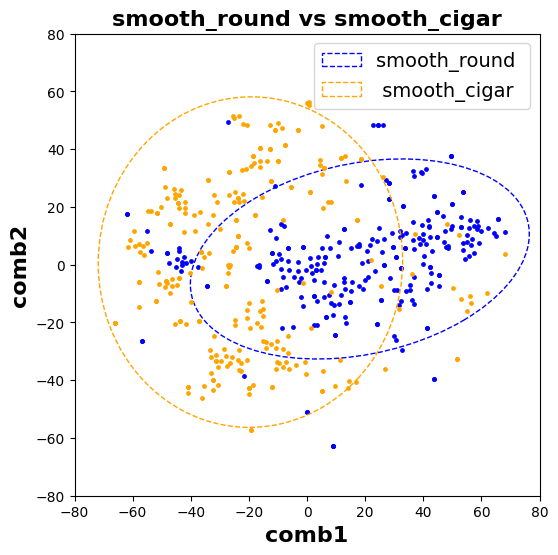

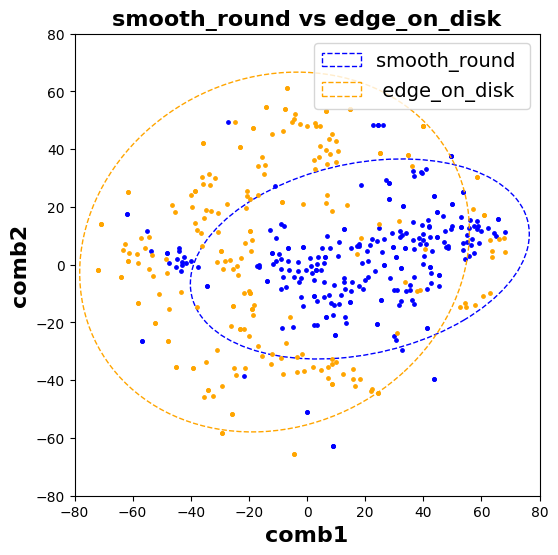

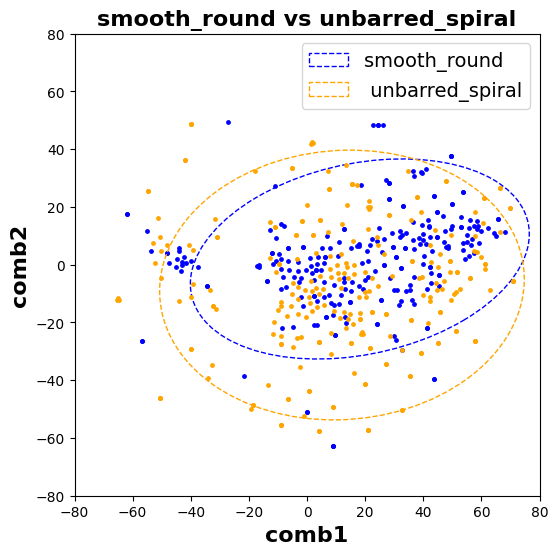

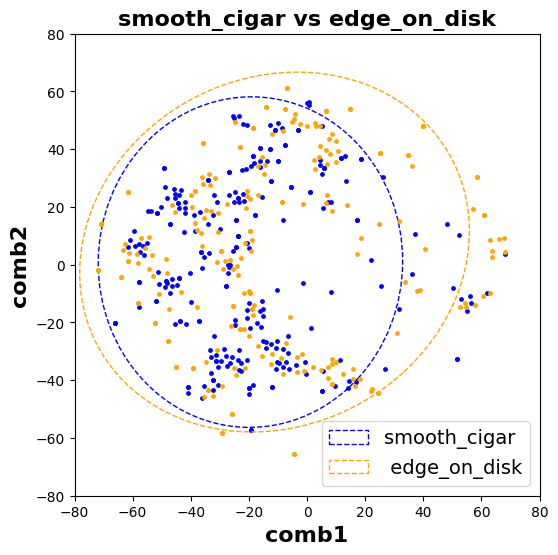

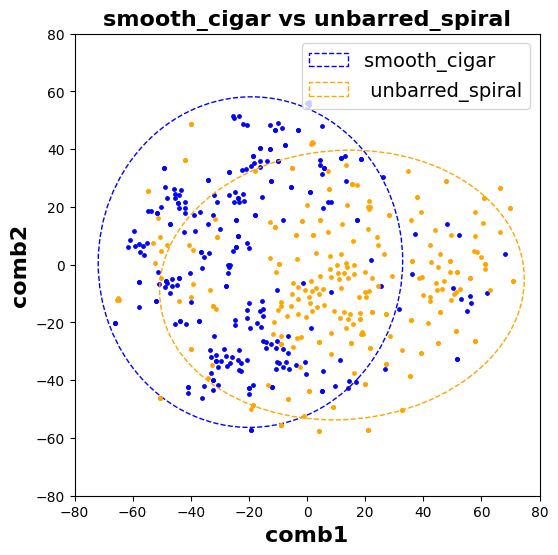

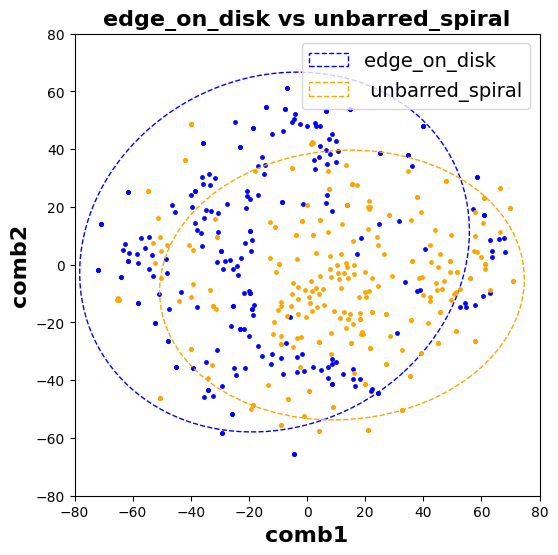

In [ ]:
for cc in comb_class:
    class_i = (np.array(labels_train) == classes.index(cc[0]) )[idx] # we can restrict the number of samples from here
    class_j = (np.array(labels_train) == classes.index(cc[1]) )[idx]
    draw_confidence_ellipse (tsne_sample[:, 0][class_i], tsne_sample[:, 1][class_i], tsne_sample[:, 0][class_j], tsne_sample[:, 1][class_j], "comb1", "comb2", cc[0]+" vs "+cc[1], (-80,80), (-80,80))

### Linear Discriminant Analysis

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [40]:
lda_sample = LinearDiscriminantAnalysis(n_components=2).fit_transform(np.array(auto_df_train)[idx])

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
tsne_sample = TSNE(n_components=2, init='pca', perplexity=10, learning_rate = 10).fit_transform(np.array(auto_df_train)[idx])

for cc in comb_class:
    class_i = (np.array(labels_train) == classes.index(cc[0]) )[idx] # we can restrict the number of samples from here
    class_j = (np.array(labels_train) == classes.index(cc[1]) )[idx]
    draw_confidence_ellipse (tsne_sample[:, 0][class_i], tsne_sample[:, 1][class_i], tsne_sample[:, 0][class_j], tsne_sample[:, 1][class_j], "comb1", "comb2", cc[0]+" vs "+cc[1], (-80,80), (-80,80))